<a href="https://colab.research.google.com/github/mark-morelos/DS-Unit-2-Applied-Modeling/blob/master/Copy_of_u2_s3_sc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [48]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [49]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [50]:
df = pd.concat([train, test], axis=0)
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [51]:
import numpy as np

# drop NA values for target column
df = df.dropna(subset=['Fail'])

# replace spaces in column names with underscores
df.columns = df.columns.str.replace(' ','_')

# convert target column to boolean for categorical feature
df['Failed?'] = df['Fail'].astype(bool)

# convert Inspection Date to datetime to be used for Test/Train/Split later
df['Inspection_Date'] = pd.to_datetime(df['Inspection_Date'])

# drop Fail column
df = df.dropna(subset=['Fail'])

df.head(5)

,Inspection_ID,DBA_Name,AKA_Name,License_#,Facility_Type,Risk,Address,City,State,Zip,Inspection_Date,Inspection_Type,Violations,Latitude,Longitude,Location,Fail,Failed?
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,True
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,False
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,False
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,False
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,False


In [52]:
# check for classes, frequency and distribution

y = df['Failed?']
y.value_counts(normalize=True)

False    0.741397
True     0.258603
Name: Failed?, dtype: float64

In [53]:
# further explore and cleaning

# remove high-cardinality features
df = df.drop(columns=['DBA_Name', 'AKA_Name', 'License_#', 'Address', 'City', 'State', 'Zip', 'Location'])


In [54]:
# fill missing values with "Missing"
df=df.fillna('Missing')

In [55]:
# creating time-based split

train = df[df['Inspection_Date'].dt.year <=2014]
val = df[(df['Inspection_Date'].dt.year >2014) & (df['Inspection_Date'].dt.year <=2017)]
test = df[df['Inspection_Date'].dt.year >2017]

# set target
target = 'Failed?'

#set features
features = train.columns.drop([target, 'Inspection_Date'])

# define train, val, test
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# define pipeline
pipeline = make_pipeline(
  ce.OrdinalEncoder(),
  DecisionTreeClassifier(max_depth=3)
)

# run pipeline on training
pipeline.fit(X_train, y_train)

# validation accuracy
print('Accuracy', pipeline.score(X_val, y_val))

# calculate ROC AUC with sklearn
from sklearn.metrics import roc_auc_score

# predicted probabilities
y_pred_proba = pipeline.predict_proba(X_val)[:, -1]

# calculate AUC
auc = roc_auc_score(y_val, y_pred_proba)
print('AUC:', auc)


Accuracy 1.0
AUC: 1.0


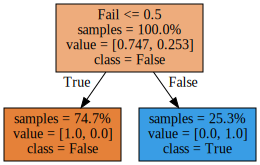

In [56]:
# visualize the decision tree

import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    out_file=None,
    feature_names=X_train.columns,
    class_names=y_train.unique().astype(str),
    filled=True,
    impurity=False,
    proportion=True
)

graphviz.Source(dot_data)

In [57]:
# The feature with leakage is 'Fail' this was the actual result of the inspection
# and must be removed. This was done on Part 2 modeling below.

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [58]:
# drop the column with leakage
features = train.columns.drop([target, 'Inspection_Date', 'Fail'])

#redefine x_train and x_val
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

#make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=3)
)

#fit model
pipeline.fit(X_train, y_train)

#Print accuracy on val
print('Accuracy', pipeline.score(X_val, y_val))

# predicted probabilities
y_pred_proba = pipeline.predict_proba(X_val)[:, -1]

# calculate AUC
auc = roc_auc_score(y_val, y_pred_proba)
print('AUC:', auc)

Accuracy 0.754641427011285
AUC: 0.6185949570005705


In [64]:
# Test Validation

# drop the column with leakage
features = test.columns.drop([target, 'Inspection_Date', 'Fail'])

X_test = test[features]
y_test = test[target]

# define pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# run pipeline on test
pipeline.fit(X_test, y_test)

# print validation accuracy
print('Accuracy', pipeline.score(X_test, y_test))

# predicted probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, -1]

# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc)

Accuracy 1.0
AUC: 1.0


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [60]:
# PDP 1 feature isolation

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

X = X_train
y = y_train

encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

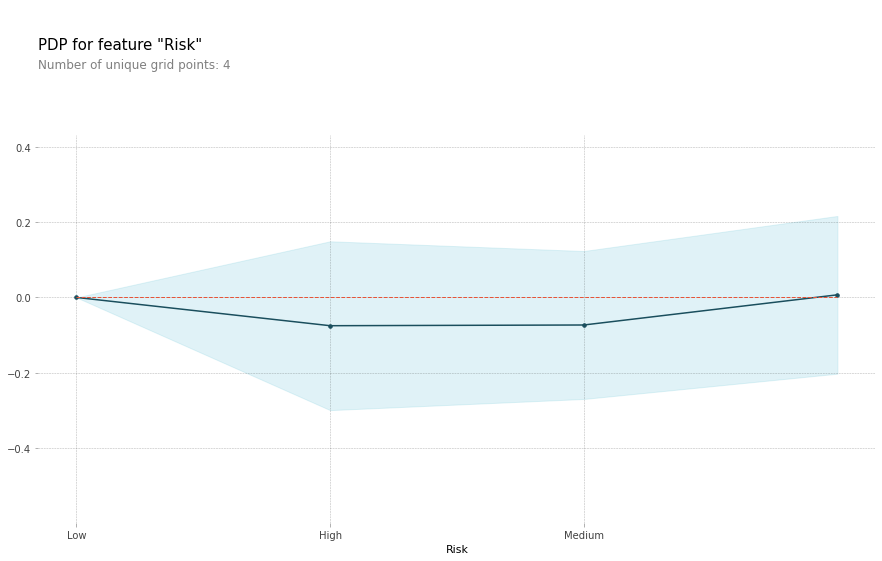

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'Risk'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([1, 2, 3], ['Low', 'High', 'Medium']);

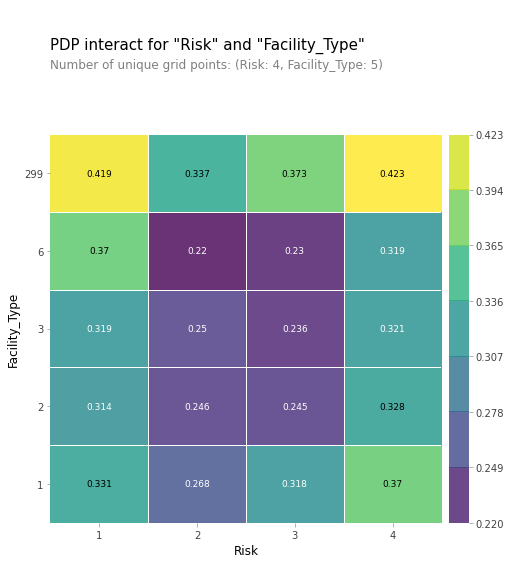

In [62]:
# PDP 2 features interaction

from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Risk', 'Facility_Type']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);